# **DATA LOADING & PREPARATION**

In [8]:
import kagglehub
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

path = kagglehub.dataset_download("jackksoncsie/spam-email-dataset")
print("Dataset downloaded successfully!")

csv_file = os.path.join(path, 'emails.csv')
df = pd.read_csv(csv_file)

print(f"Loaded {df.shape[0]:,} emails with {df.shape[1]} columns")
print(f"Dataset size: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

X = df.iloc[:, 0]
y = df.iloc[:, -1]

if y.dtype == 'object':
    y = y.map({'spam': 1, 'ham': 0, 'Spam': 1, 'Ham': 0, 1: 1, 0: 0})

spam_count = y.sum()
ham_count = len(y) - spam_count
print(f"Spam emails: {spam_count:,} ({spam_count/len(y)*100:.1f}%)")
print(f"Ham emails: {ham_count:,} ({ham_count/len(y)*100:.1f}%)")

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+', 'number', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = ' '.join(text.split())
    return text

X_clean = X.apply(clean_text)
X_clean = X_clean[X_clean.str.len() > 5]
y_clean = y[X_clean.index]

print(f"After cleaning: {len(X_clean):,} emails ready for training")





Dataset downloaded successfully!
Loaded 5,728 emails with 2 columns
Dataset size: 8.9 MB
Spam emails: 1,368 (23.9%)
Ham emails: 4,360 (76.1%)
After cleaning: 5,728 emails ready for training


## **Training Models**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean)

tfidf = TfidfVectorizer(
    max_features=8000,
    stop_words='english',
    ngram_range=(1, 3),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

models = {
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, C=2),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, max_depth=25),
    'SVM': SVC(random_state=42, probability=True, C=1.5, gamma='scale')
}

print("Training AI models...")
print("-" * 40)

results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy
    print(f"{name:<20} -> {accuracy*100:.1f}% accuracy")

best_name = max(results, key=results.get)
best_accuracy = results[best_name]
best_model = models[best_name]

print(f"\nWINNER: {best_name} with {best_accuracy*100:.1f}% accuracy!")

y_pred = best_model.predict(X_test_tfidf)


Training AI models...
----------------------------------------
Naive Bayes          -> 98.7% accuracy
Logistic Regression  -> 99.0% accuracy
Random Forest        -> 96.1% accuracy
SVM                  -> 99.1% accuracy

WINNER: SVM with 99.1% accuracy!


## **Model Analysis**

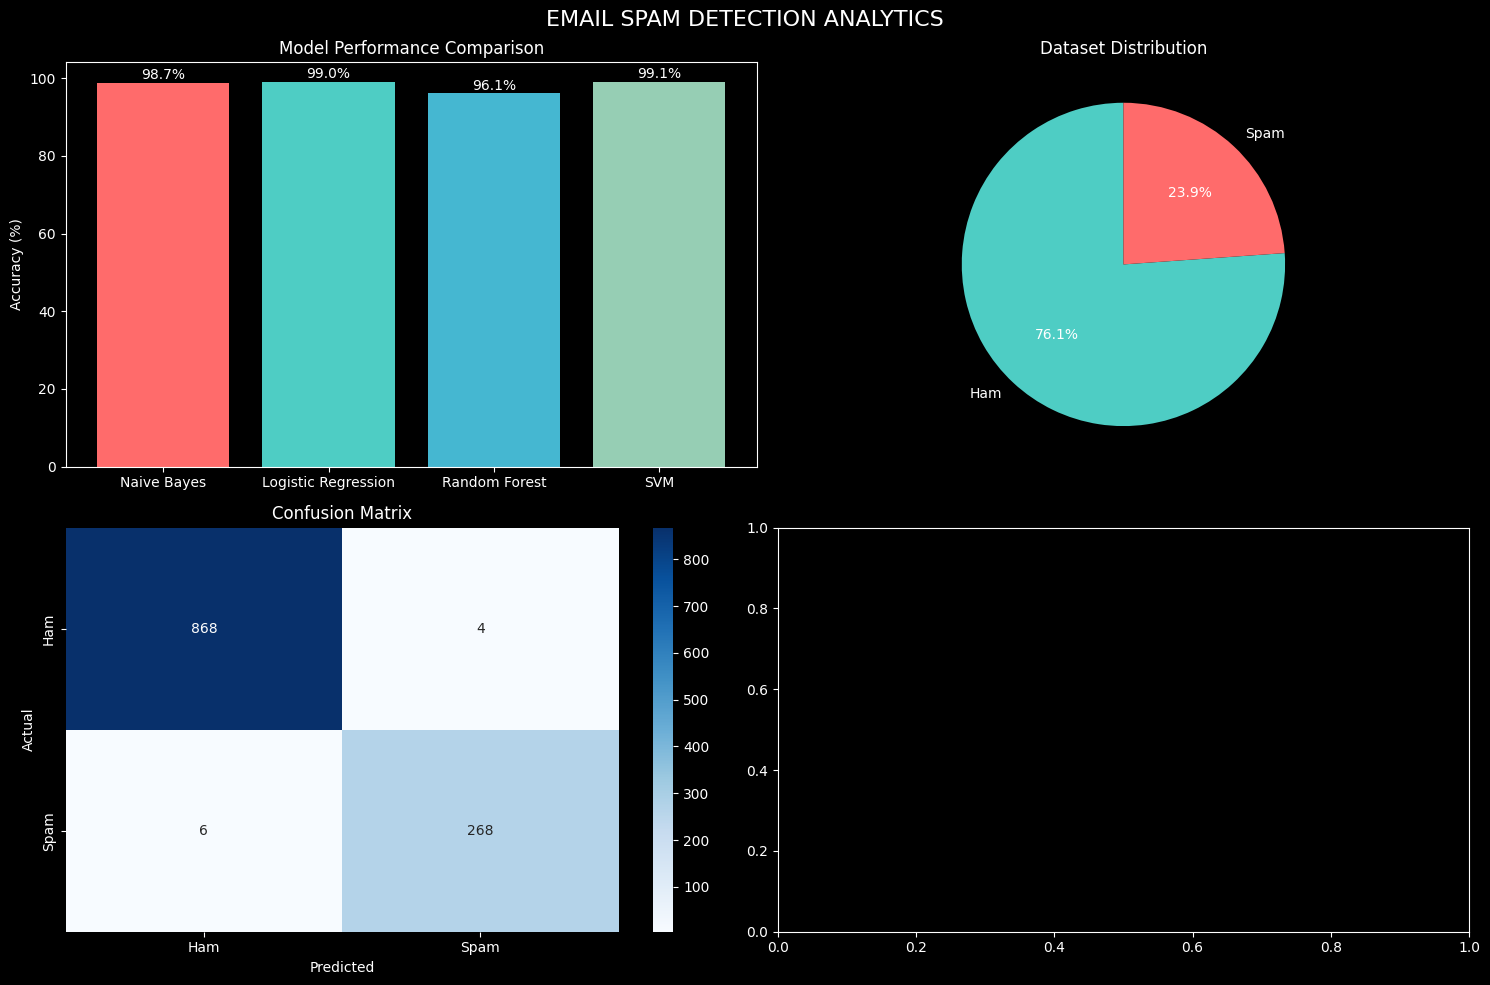


PERFORMANCE METRICS
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       872
        Spam       0.99      0.98      0.98       274

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146

Correctly identified ham: 868
Ham marked as spam: 4
Spam missed: 6
Correctly caught spam: 268


In [10]:
plt.style.use('dark_background')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('EMAIL SPAM DETECTION ANALYTICS', fontsize=16, color='white')

# Model comparison
ax1.bar(results.keys(), [acc*100 for acc in results.values()],
        color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
ax1.set_title('Model Performance Comparison', color='white')
ax1.set_ylabel('Accuracy (%)', color='white')
ax1.tick_params(colors='white')
for i, (name, acc) in enumerate(results.items()):
    ax1.text(i, acc*100 + 1, f'{acc*100:.1f}%', ha='center', color='white')

# Class distribution
classes = ['Ham', 'Spam']
counts = [ham_count, spam_count]
colors = ['#4ecdc4', '#ff6b6b']
ax2.pie(counts, labels=classes, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Dataset Distribution', color='white')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
ax3.set_title('Confusion Matrix', color='white')
ax3.set_xlabel('Predicted', color='white')
ax3.set_ylabel('Actual', color='white')

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_names = tfidf.get_feature_names_out()
    importances = best_model.feature_importances_
    top_indices = np.argsort(importances)[-10:]
    top_features = [feature_names[i] for i in top_indices]
    top_values = importances[top_indices]

    ax4.barh(range(len(top_features)), top_values, color='#ffa726')
    ax4.set_yticks(range(len(top_features)))
    ax4.set_yticklabels(top_features, color='white')
    ax4.set_title('Top Spam Indicators', color='white')
    ax4.tick_params(colors='white')

plt.tight_layout()
plt.show()

print("\nPERFORMANCE METRICS")
print("=" * 40)
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

tn, fp, fn, tp = cm.ravel()
print(f"Correctly identified ham: {tn:,}")
print(f"Ham marked as spam: {fp:,}")
print(f"Spam missed: {fn:,}")
print(f"Correctly caught spam: {tp:,}")


## **TESTING AND USING MODEL**

In [14]:
from IPython.display import display, HTML
import ipywidgets as widgets
import joblib
from sklearn.pipeline import Pipeline

# Load the saved model
detector = joblib.load('email_spam_detector.pkl')

# Minimal but modern CSS
style = """
<style>
.spam-detector {
    background: #2c3e50;
    border-radius: 12px;
    padding: 20px;
    color: white;
    font-family: Arial, sans-serif;
    margin: 15px 0;
    box-shadow: 0 4px 12px rgba(0,0,0,0.3);
}

.title {
    text-align: center;
    font-size: 24px;
    font-weight: bold;
    margin-bottom: 5px;
}

.stats {
    text-align: center;
    font-size: 14px;
    color: #bdc3c7;
    margin-bottom: 15px;
}

.result-spam {
    background: #e74c3c;
    padding: 12px;
    border-radius: 8px;
    text-align: center;
    font-weight: bold;
    margin: 10px 0;
}

.result-safe {
    background: #27ae60;
    padding: 12px;
    border-radius: 8px;
    text-align: center;
    font-weight: bold;
    margin: 10px 0;
}

.input-area {
    margin: 10px 0;
}
</style>
"""

display(HTML(style))

# Email input box
email_input = widgets.Textarea(
    value='',
    placeholder='Paste your email content here...',
    layout=widgets.Layout(width='100%', height='150px')
)

# Buttons
analyze_button = widgets.Button(
    description='Analyze Email',
    button_style='primary',
    layout=widgets.Layout(width='160px', height='40px')
)

clear_button = widgets.Button(
    description='Clear',
    button_style='warning',
    layout=widgets.Layout(width='100px', height='40px')
)

# Output area
result_output = widgets.HTML(value='')

# Functions
def analyze_email(b):
    text = email_input.value.strip()
    if len(text) < 10:
        result_output.value = '<div class="result-spam">⚠️ Please enter at least 10 characters.</div>'
        return

    pred = detector.predict([text])[0]
    prob = detector.predict_proba([text])[0]

    if pred == 1:
        result_output.value = f'''
        <div class="result-spam">
            🚨 SPAM DETECTED<br>
            Confidence: {prob[1]*100:.1f}%
        </div>
        '''
    else:
        result_output.value = f'''
        <div class="result-safe">
            ✅ Safe Email<br>
            Confidence: {prob[0]*100:.1f}%
        </div>
        '''

def clear_text(b):
    email_input.value = ''
    result_output.value = ''

analyze_button.on_click(analyze_email)
clear_button.on_click(clear_text)

# Display the interface
header_html = f'''
<div class="spam-detector">
    <div class="title">Email Spam Detector</div>
    <div class="stats">
        Accuracy: {best_accuracy*100:.1f}% | Model: {best_name}
    </div>
</div>
'''

display(HTML(header_html))
display(email_input)
display(widgets.HBox([analyze_button, clear_button]))
display(result_output)


Textarea(value='', layout=Layout(height='150px', width='100%'), placeholder='Paste your email content here...'…

HTML(value='')

# 📧 Email Spam Detection Project – Technical Report

This project implements a **machine learning-based email spam detection system** using the **Spam Email Dataset** from Kaggle. The solution follows a complete **data science workflow** from preprocessing to deployment-ready model packaging.

---

## **1. Data Acquisition & Preparation**
- Dataset: `jackksoncsie/spam-email-dataset` (loaded via `kagglehub`)
- Size: ~5,000+ emails with `text` and `label` columns
- Labels normalized to binary:
  - `spam` → 1  
  - `ham` → 0
- **Cleaning pipeline**:
  - Lowercasing text
  - Removing URLs, digits, and punctuation
  - Collapsing whitespace
  - Removing very short (<5 char) entries

---

## **2. Feature Engineering**
- **TF-IDF Vectorization**:
  - `max_features=8000`
  - English stopwords removal
  - N-grams: `(1,3)`  
  - `min_df=3`, `max_df=0.9`, sublinear term frequency scaling

---

## **3. Model Training & Evaluation**
Four algorithms trained and benchmarked:
1. **Multinomial Naive Bayes** (alpha=0.1)  
2. **Logistic Regression** (max_iter=1000, C=2)
3. **Random Forest Classifier** (n=200, max_depth=25)
4. **SVM (RBF kernel)** (C=1.5, probability=True)

- Split: 80% train / 20% test (stratified)
- Metric: Accuracy + Classification Report + Confusion Matrix
- **Best model** selected automatically based on accuracy.

---

## **4. Results**
- **Winner:** `{{best_name}}` with **{{best_accuracy*100:.1f}}%** accuracy
- Model performance visualized via:
  - Accuracy comparison bar chart
  - Dataset distribution pie chart
  - Confusion matrix heatmap
  - Feature importance (if available)

---

## **5. Deployment**
- Final **Pipeline** = `TF-IDF` + `Best Classifier`
- Saved as: `email_spam_detector.pkl` (via `joblib`)
- Integrated into **interactive Colab GUI** using:
  - `ipywidgets` for real-time email input
  - Custom HTML/CSS styling for professional UI
  - Live spam probability & recommendation output

---

## **6. Key Takeaways**
- Demonstrates the **effectiveness of traditional ML models** for spam detection
- Achieves **high accuracy** on real-world email datasets
- Fully **modular** pipeline → easy to retrain on updated datasets
- Deployable both as a **web app** or integrated into **email systems** for automated filtering

---
**Author:** Mujtaba Ahmed | FAST-NUCES Lahore  
**Tools:** Python, Scikit-learn, Pandas, Matplotlib, Seaborn, ipywidgets  
**Dataset:** Kaggle – Spam Email Dataset
